Customer Segmentation | Clustering | AutoEncoder

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data = pd.read_csv('sales_data_sample.csv', encoding= 'unicode_escape')
data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [3]:
#Checking for null values
data.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [4]:
#Drop lot of Null values and unused columns
data.drop(['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER', 'COUNTRY'], axis=1, inplace=True)
data.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,DEALSIZE
0,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,S10_1678,Small
1,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,S10_1678,Small
2,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,S10_1678,Medium
3,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,Motorcycles,95,S10_1678,Medium
4,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,95,S10_1678,Medium


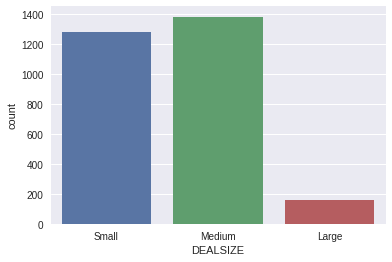

In [5]:
sns.countplot(x='DEALSIZE',data=data);

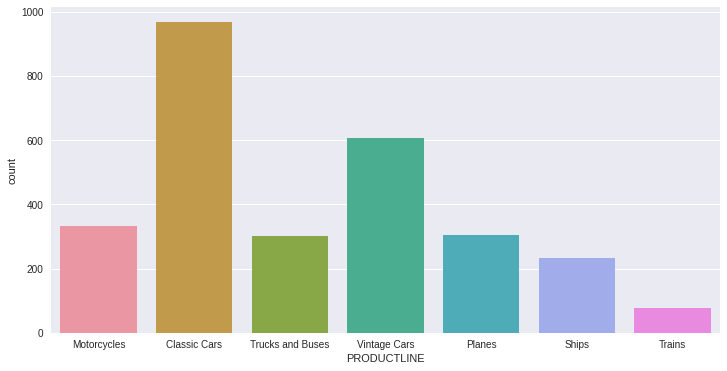

In [6]:
plt.figure(figsize=(12,6))
sns.countplot(x='PRODUCTLINE',data=data);

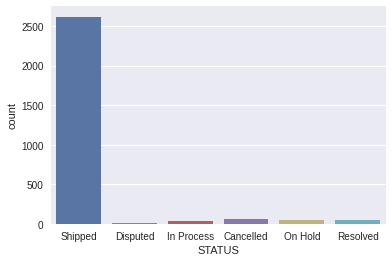

In [7]:
sns.countplot(x='STATUS',data=data);

In [8]:
#Encoding Categorical Variables
status_dict = {'Shipped':1, 'Cancelled':2, 'On Hold':2, 'Disputed':2, 'In Process':0, 'Resolved':0}
data['STATUS'].replace(status_dict, inplace=True)

In [9]:
data.PRODUCTLINE.value_counts()

Classic Cars        967
Vintage Cars        607
Motorcycles         331
Planes              306
Trucks and Buses    301
Ships               234
Trains               77
Name: PRODUCTLINE, dtype: int64

In [10]:
product_dict = {'Classic Cars':0, 'Vintage Cars':1, 'Motorcycles':2, 'Planes':3, 'Trucks and Buses':4, 'Ships':5, 'Trains':6}
data['PRODUCTLINE'].replace(product_dict, inplace=True)

In [11]:
deal_dict = {'Small':0, 'Medium':1, 'Large':2}
data['DEALSIZE'].replace(deal_dict, inplace=True)
data.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,DEALSIZE
0,30,95.70,2,2871.00,2/24/2003 0:00,1,1,2,2003,2,95,S10_1678,0
1,34,81.35,5,2765.90,5/7/2003 0:00,1,2,5,2003,2,95,S10_1678,0
2,41,94.74,2,3884.34,7/1/2003 0:00,1,3,7,2003,2,95,S10_1678,1
3,45,83.26,6,3746.70,8/25/2003 0:00,1,3,8,2003,2,95,S10_1678,1
4,49,100.00,14,5205.27,10/10/2003 0:00,1,4,10,2003,2,95,S10_1678,1


In [12]:
data.ORDERDATE = pd.to_datetime(data.ORDERDATE)
date_group = data.groupby('ORDERDATE').sum()
date_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,DEALSIZE
ORDERDATE,,,,,,,,,,,
2003-01-06,151,288.78,10,12133.25,4,4,4,8012,4,363,2
2003-01-09,142,284.96,10,11432.34,4,4,4,8012,4,372,2
2003-01-10,80,150.14,3,6864.05,2,2,2,4006,2,155,1
2003-01-29,541,1417.54,136,54702.00,16,16,16,32048,34,1695,10
2003-01-31,443,1061.89,91,44621.96,13,13,13,26039,28,1365,8
...,...,...,...,...,...,...,...,...,...,...,...
2005-05-13,259,561.18,21,31821.90,12,12,30,12030,12,728,7
2005-05-17,509,1269.43,105,59475.10,14,28,70,28070,0,1669,12
2005-05-29,607,1148.40,94,51233.18,0,30,75,30075,8,1328,8


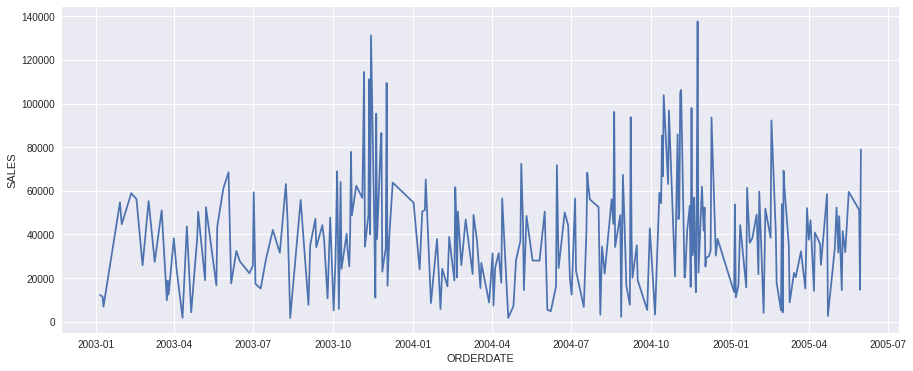

In [13]:
#Sales vs Date plot
plt.figure(figsize=(15,6))
sns.lineplot(x = date_group.index, y = date_group.SALES);

In [14]:
data.drop(['ORDERDATE','PRODUCTCODE'],axis=1,inplace=True)

In [15]:
#StandardScaler: It transforms the data in such a manner that it has mean as 0 and standard deviation as 1.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [16]:
data.shape

(2823, 11)

An autoencoder is an unsupervised learning technique for neural networks that learns efficient data representations (encoding) by training the network to ignore signal “noise.” An autoencoder is a fairly simple deep neural network. It will ingest the data set through a step of hidden layers, learn common and essential behavior and filter out the lesser ones.

In [17]:
input_df = Input(shape =(11,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(11, kernel_initializer = 'glorot_uniform')(x)

#autoencoder
autoencoder = Model(input_df, decoded)

#encoder - used for dimensionality reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

We’ll create an input layer to ingest the data then pass it through a dense layer with a Relu activation (rectified linear unit that will keep positive numbers and set any negative ones to zero) and the learning rate set earlier. We do that a few more times as we reduce the data then rebuild it. Finally, we pass it through the final dense layer with a linear activation that will output the data in its original dimension (prior to modeling).

In [18]:
autoencoder.fit(data,data, batch_size=128, epochs=100, verbose=3)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [19]:
encoded_data = autoencoder.predict(scaled_data)

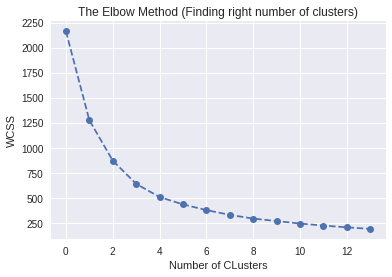

In [20]:
#Optimal number of cluster using elbow method
wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(encoded_data)
    wcss.append(kmeans.inertia_) #intertia is the Sum of squared distances of samples to their closest cluster center (WCSS)

plt.plot(wcss, marker='o', linestyle='--')
plt.title('The Elbow Method (Finding right number of clusters)')
plt.xlabel('Number of CLusters')
plt.ylabel('WCSS')
plt.show()

In [21]:
#From the above layer 3 clusters seems best choice
kmeans = KMeans(3)
kmeans.fit(encoded_data)
labels = kmeans.labels_
y = kmeans.fit_predict(scaled_data)

In [22]:
cluster_data = pd.concat([data, pd.DataFrame({'cluster':labels})], axis = 1)
cluster_data.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,DEALSIZE,cluster
0,30,95.70,2,2871.00,1,1,2,2003,2,95,0,0
1,34,81.35,5,2765.90,1,2,5,2003,2,95,0,0
2,41,94.74,2,3884.34,1,3,7,2003,2,95,1,0
3,45,83.26,6,3746.70,1,3,8,2003,2,95,1,0
4,49,100.00,14,5205.27,1,4,10,2003,2,95,1,0


In [23]:
cluster_data.cluster.value_counts()

0    1690
1     778
2     355
Name: cluster, dtype: int64

Cluster 0 - This group represents customers who buy items in high quantity \
Cluster 1 - This group represents customers who buy items in average quantity \
Cluster 2 - This group represents customers who buy items in small quantity

In [24]:
#Reduce the original data to 3 dimension using PCA for visualize the clusters
pca = PCA(n_components = 3)
prin_comp = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,-0.592484,1.305975,-0.922027,0
1,-0.890459,0.272780,-0.292774,0
2,0.765541,-0.559988,0.474674,0
3,0.534947,-0.739748,0.959425,0
4,1.319113,-1.728532,1.234146,0


In [25]:
px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3', color='cluster')